In [124]:
import numpy as np
import pandas as pd
import string
from numba import njit
import matplotlib.pyplot as plt

# Preprocessing
- dataset - contains sentences in 0 and sentences score in 1
- train,tes - divided dataset
- words - contains number of occurences of 2000 most popular words
- vocab - contains mapping from word to number
- sent,words_vec - sent is scores for each sentence and words_vec is numpy matrix of sentences mapped to vectors

In [97]:
file = open("train.tsv",'r')
line = file.readline()
#first cell is phrase id
#third cell is sentence id
#last cell is enter and sentece[-2] is sentiment
dataset = {}
act = 0
cnt = 0
while True:
    line = file.readline()
    if not line:
        break
    phrase,ite = 0,0
    while line[ite] != '\t':
        phrase *= 10
        phrase += int(line[ite])
        ite += 1
    ite += 1
    sentence = 0
    while line[ite] != '\t':
        sentence *= 10
        sentence += int(line[ite])
        ite += 1
    if act != sentence:
        act = sentence
        cnt+=1
        dataset[cnt] = (line[(ite+1):-3],int(line[-2])/4)

In [98]:
train,test = {},{}
for key in dataset.keys():
    dataset[key] = (dataset[key][0].translate(str.maketrans('', '', string.punctuation)),dataset[key][1])
    if key <= 7000:
        train[key] = dataset[key]
    else:
        test[key] = dataset[key]

In [99]:
words = {}
for key in dataset.keys():
    sentence = dataset[key][0]
    word = ""
    for s in sentence:
        if s == ' ':
            if word == "":
                continue
            if not word in words:
                words[word] = 0
            words[word] += 1
            word = ""
        else:
            word += s.lower()

In [100]:
words

{'a': 5235,
 'series': 49,
 'of': 4340,
 'escapades': 1,
 'demonstrating': 3,
 'the': 7233,
 'adage': 3,
 'that': 1937,
 'what': 338,
 'is': 2537,
 'good': 264,
 'for': 1019,
 'goose': 3,
 'also': 115,
 'gander': 1,
 'some': 236,
 'which': 188,
 'occasionally': 27,
 'amuses': 1,
 'but': 1166,
 'none': 28,
 'amounts': 8,
 'to': 2996,
 'much': 263,
 'story': 345,
 'this': 994,
 'quiet': 24,
 'introspective': 3,
 'and': 4420,
 'entertaining': 91,
 'independent': 4,
 'worth': 78,
 'seeking': 5,
 'even': 256,
 'fans': 54,
 'ismail': 1,
 'merchant': 5,
 's': 2521,
 'work': 175,
 'i': 422,
 'suspect': 6,
 'would': 188,
 'have': 458,
 'hard': 89,
 'time': 229,
 'sitting': 17,
 'through': 144,
 'one': 553,
 'positively': 5,
 'thrilling': 3,
 'combination': 12,
 'ethnography': 1,
 'all': 461,
 'intrigue': 12,
 'betrayal': 4,
 'deceit': 1,
 'murder': 20,
 'shakespearean': 2,
 'tragedy': 27,
 'or': 374,
 'juicy': 4,
 'soap': 26,
 'opera': 33,
 'aggressive': 2,
 'selfglorification': 2,
 'manipulati

In [101]:
words = sorted(words.items(), key=lambda x: x[1])
words = words[-2000:]
words = dict(words)

In [102]:
cnt = 0
vocab = {}
for key in words.keys(): 
    vocab[key] = cnt
    cnt+=1

In [103]:
words_vec = np.zeros((7000,2000))
sent = np.zeros(7000)
for key in train.keys():
    sentence = train[key][0]
    sent[key-1] = train[key][1]
    word = ""
    for s in sentence:
        if s == ' ':
            if word == "":
                continue
            if word in vocab:
                words_vec[key-1,vocab[word]] += 1
            word = ""
        else:
            word += s.lower()

In [104]:
test_sent = np.zeros(1529)
test_words_vec = np.zeros((1529,2000))
for key in test.keys():
    test_sent[key-7001] = test[key][1]
    sentence = test[key][0]
    word = ""
    for s in sentence:
        if s == ' ':
            if word == "":
                continue
            if word in vocab:
                test_words_vec[key-7001,vocab[word]] += 1
            word = ""
        else:
            word += s.lower()

# Basic
We are optimizing Theta (weight for each word) using scipy optimize, due to random initialization and big ammount of local minima results can vary beetwen each other but in general MSE is no lower than 0.225 and no higher than 0.231

In [105]:
import scipy.optimize as sopt

def sigmoid(x):
    return 1/(1+np.exp(-x))

def logreg_loss(Theta, X, Y):
    #
    # Write a logistic regression cost suitable for use with fmin_l_bfgs
    #

    #reshape Theta
    probability_one = sigmoid(X.dot(Theta))+1e-100
    probability_two = 1-sigmoid(X.dot(Theta))+1e-100
    nll = -np.sum(Y.dot(np.log(probability_one))+(1-Y).dot(np.log(probability_two)))
    grad = X.T.dot((sigmoid(X.dot(Theta)) - Y))

    #reshape grad into the shape of Theta, for fmin_l_bfsgb to work
    return nll, grad.reshape(Theta.shape)

Theta = np.random.normal(size=2000)
ThetaOpt = sopt.fmin_l_bfgs_b(lambda Theta: logreg_loss(Theta, words_vec, sent), Theta)[0]

In [106]:
print(np.mean(np.abs(sigmoid(test_words_vec.dot(ThetaOpt))-test_sent)))

0.2305865302543854


#  Simple analysis of results
After checking which words has highest and lowest weight we can find that this in fact corresponds to word meaning,
ex. masterpiece is clearly good opinion word when unpleasant is clearly negative.

In [107]:
cnt = 0
rev_vocab = {}
for key in words.keys(): 
    rev_vocab[cnt] = key
    cnt+=1

negatives = np.argsort(ThetaOpt)
print("Negatives:\n")
for i in range(20):
    print(rev_vocab[negatives[i]])
    
print("\nPositives:\n")
for i in range(20):
    print(rev_vocab[negatives[-(i+1)]])

Negatives:

unpleasant
devoid
wannabe
stealing
lacking
unnecessary
crap
ripoff
stupid
worst
shoot
horrible
poor
hip
listless
disguise
poorly
alabama
lazy
car

Positives:

captivating
dazzling
amused
delightfully
masterpiece
refreshing
follow
feelgood
intoxicating
determination
mesmerizing
suspenseful
assured
remarkably
wonderfully
holds
vibrant
remarkable
originality
funniest


### Due to my limited time I only found this negations and emphasions, there are probably more but they are good enough.

In [108]:
negations = ['not','nt','neither','never','none','nobody','nor','nothing','nowhere']
emphasions = ['very','big','enormous','great','much','lot','absolute','most','complete','pure','total','totally']

We are recomputing words_vec and test_words_vec to introduce negation

In [109]:
words_vec = np.zeros((7000,2000))
sent = np.zeros(7000)
for key in train.keys():
    sentence = train[key][0]
    sent[key-1] = train[key][1]
    word = ""
    negative = 1
    for s in sentence:
        if s == ' ':
            if word == "":
                continue
            if word in vocab:
                words_vec[key-1,vocab[word]] += 1 * negative
            if word in negations:
                negative*=-1
            word = ""
        else:
            word += s.lower()

In [110]:
test_sent = np.zeros(1529)
test_words_vec = np.zeros((1529,2000))
for key in test.keys():
    test_sent[key-7001] = test[key][1]
    sentence = test[key][0]
    word = ""
    negative = 1
    for s in sentence:
        if s == ' ':
            if word == "":
                continue
            if word in vocab:
                test_words_vec[key-7001,vocab[word]] += 1 * negative
            if word in negations:
                negative*=-1
            word = ""
        else:
            word += s.lower()

### We got worse results than in code without negation modification, so we will try to optimize N (and E) so we maybe get something better.

In [111]:
Theta = np.random.normal(size=2000)
ThetaOpt = sopt.fmin_l_bfgs_b(lambda Theta: logreg_loss(Theta, words_vec, sent), Theta)[0]

In [112]:
print(np.mean(np.abs(sigmoid(test_words_vec.dot(ThetaOpt))-test_sent)))
print(logreg_loss(ThetaOpt,test_words_vec,test_sent))

0.24237288285425593
(1070.8350053457762, array([  0.52372216,   0.18598653,  -0.06193189, ..., -12.6301402 ,
         6.69018606, -10.87403465]))


# Neg and Emp training
So basically our "improvment" can get better results but due to fact that our function has got ridincolous ammount of local minima its hard for normal gradient descent to approach even mediocore minima. Scipy optimize gets us to 0.246 MAE which is way worse than 0.23 when we were just optimizing theta.

In [113]:
def compute_word_vectors(N,E):
    words_vec = np.zeros((7000,2000))
    words_vec_N = np.zeros((7000,2000))
    words_vec_E = np.zeros((7000,2000))
    for key in train.keys():
        sentence = train[key][0]
        word = ""
        negative = 0
        emphasis = 0
        for s in sentence:
            if s == ' ':
                if word == "":
                    continue
                if word in vocab:
                    words_vec[key-1,vocab[word]] += 1 * (N**negative) * (E**emphasis)
                    if negative != 0:
                        words_vec_N[key-1,vocab[word]] += 1 * (negative*(N**(negative-1))) * (E**emphasis)
                    if emphasis != 0:
                        words_vec_E[key-1,vocab[word]] += 1 * (N**negative) * (emphasis*(E**(emphasis-1)))
                    if word in negations:
                        negative += 1
                    if word in emphasions:
                        emphasis += 1
                word = ""
            else:
                word += s.lower()
    return words_vec,words_vec_N,words_vec_E

In [114]:
def logreg_loss_custom(Theta,Y):
    
    theta,N,E = Theta[:2000],Theta[2000],Theta[2001]
    x,xN,xE = compute_word_vectors(N,E)
    
    probability_one = sigmoid(x.dot(theta))+1e-100
    probability_two = 1-sigmoid(x.dot(theta))+1e-100
    nll = -np.sum(Y.dot(np.log(probability_one))+(1-Y).dot(np.log(probability_two)))
    
    grad = x.T.dot((sigmoid(x.dot(theta)) - Y))
    NegGrad = xN.dot(theta).T.dot(sigmoid(x.dot(theta)-Y))
    EmpGrad = xE.dot(theta).T.dot(sigmoid(x.dot(theta)-Y))
    grad = np.append(grad,NegGrad)
    grad = np.append(grad,EmpGrad)

    return nll, grad.reshape(Theta.shape)

In [115]:
Theta = np.random.normal(size = 2002)
ThetaOpt = sopt.fmin_l_bfgs_b(lambda Theta: logreg_loss_custom(Theta,sent), Theta)[0]

In [116]:
def test_update(N,E):
    test_sent = np.zeros(1529)
    test_words_vec = np.zeros((1529,2000))
    for key in test.keys():
        test_sent[key-7001] = test[key][1]
        sentence = test[key][0]
        word = ""
        negative = 0
        emphasis = 0
        for s in sentence:
            if s == ' ':
                if word == "":
                    continue
                if word in vocab:
                    test_words_vec[key-7001,vocab[word]] += 1 * (N**negative) * (E**emphasis)
                if word in negations:
                    negative += 1
                if word in emphasions:
                    emphasis += 1
                word = ""
            else:
                word += s.lower()
    return test_words_vec,test_sent

test_words_vec,test_sent = test_update(Theta[2000],Theta[2001])

In [117]:
print(np.mean(np.abs(sigmoid(test_words_vec.dot(ThetaOpt[:2000]))-test_sent)))
print(ThetaOpt[2000],ThetaOpt[2001])

0.24608012682252595
0.08748417104808222 -0.2667970045955598


#### I used code below to somehow brutally check if there are really no better scores than 0.246 for logreg with N and E and well, there are better N and E than what sopt found.
After testing it and wondering why it works poorly I discovered that it is impossible for sopt to do it correcly, as we can see from N and E values that we get which intuitively are not correct.

In [ ]:
bestR = np.array([1,0,0])
for N in np.arange(-2,2,0.1):
    for E in np.arange(-2,2,0.1):
        words_vec_norm = compute_word_vectors(N,E)[0]
        Theta = np.random.normal(size=2000)
        ThetaOpt = sopt.fmin_l_bfgs_b(lambda Theta: logreg_loss(Theta, words_vec_norm, sent), Theta)[0]
        print(N,E)
        print(np.mean(np.abs(sigmoid(test_words_vec.dot(ThetaOpt))-test_sent)))
        if np.mean(np.abs(sigmoid(test_words_vec.dot(ThetaOpt))-test_sent)) < bestR[0]:
            bestR[0] = np.mean(np.abs(sigmoid(test_words_vec.dot(ThetaOpt))-test_sent))
            bestR[1] = N
            bestR[2] = E
print(bestR)

# Solution
So I propose solution to our problem, firstly I will try approaching it with Alternating Least Squares idea. We will make N and E constant then fully optimize theta, after that we will keep theta constant and optimize N and E, and repeat it few/a lot of times. With this approach it is really important to choose starting N and E correctly - as could be seen in previous example we will be stuck in local minima really fast. We should also take a notice that N and E does not really count as model parameters, I would rather treat them as hyperparameters and with that in mind I will also try another approach.

In [118]:
def logreg_loss_als_theta(theta,x,y):
    Sw = x.T.dot(sigmoid(x.dot(theta)) - y)
    
    probability_one = sigmoid(x.dot(theta))+1e-100
    probability_two = 1-sigmoid(x.dot(theta))+1e-100
    nll = -np.sum(y.dot(np.log(probability_one))+(1-y).dot(np.log(probability_two)))
    
    return nll,Sw

def logreg_loss_als_NE(theta,NE,y):
    N = NE[0]
    E = NE[1]
    x,xN,xE = compute_word_vectors(N,E)
    Neg = xN.dot(theta).T.dot(sigmoid(x.dot(theta)) - y)
    Emp = xE.dot(theta).T.dot(sigmoid(x.dot(theta)) - y)
    
    probability_one = sigmoid(x.dot(theta))+1e-100
    probability_two = 1-sigmoid(x.dot(theta))+1e-100
    nll = -np.sum(y.dot(np.log(probability_one))+(1-y).dot(np.log(probability_two)))
    grad = np.array([Neg,Emp])
    
    return nll,grad

[1. 1.]
[0.22892726 0.7390098  1.10712865]


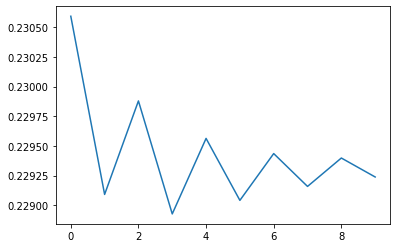

[-1.  1.]
[0.22955821 0.1455407  1.08200421]


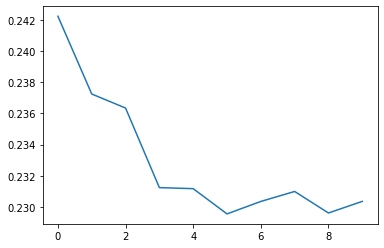

[-1. -1.]
[0.22991564 0.27053979 0.65027876]


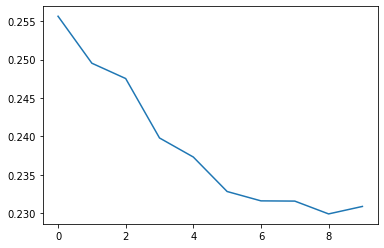

[ 1. -1.]
[0.22926505 0.66819055 0.76448888]


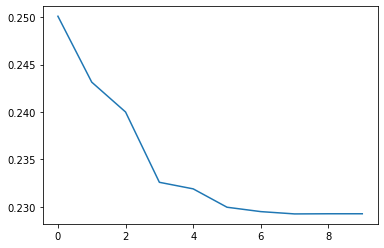

[1.5 1.5]
[0.22927315 0.71630076 1.29178838]


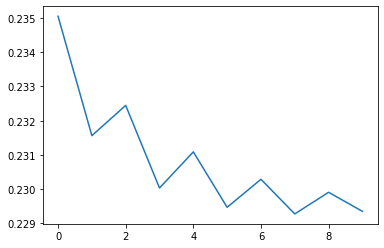

[-1.5  1.5]
[0.22931413 0.03120679 1.25437484]


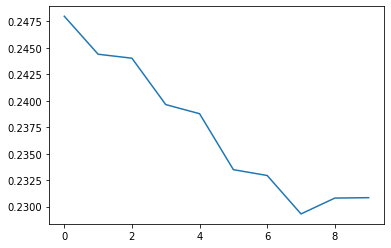

[ 1.5 -1.5]
[0.22922171 0.70694584 0.7648785 ]


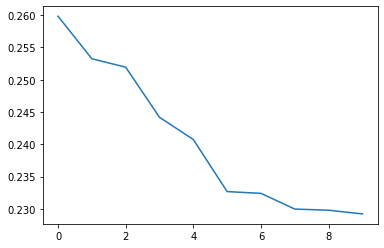

[-1.5 -1.5]
[0.23170159 0.13564899 0.59560511]


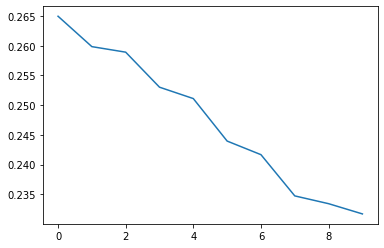

[2. 2.]
[0.22964409 0.72141319 1.38984459]


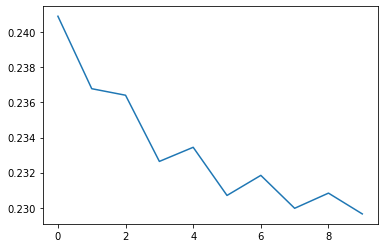

[-2.  2.]
[ 0.23088843 -0.13379595  1.40610631]


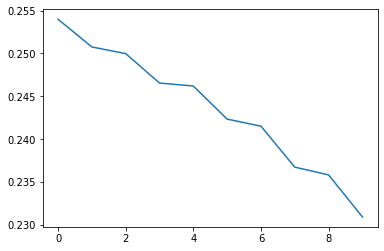

[ 2. -2.]
[0.2303575  0.82621205 0.48281892]


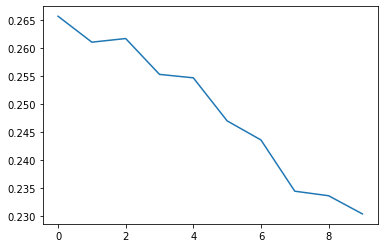

[-2. -2.]
[ 0.24004518 -0.52724009  0.18464935]


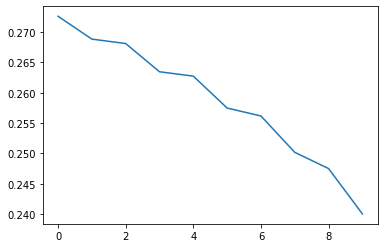

In [143]:
params = np.array([[1,1],[-1,1],[-1,-1],[1,-1],[1.5,1.5],[-1.5,1.5],[1.5,-1.5],[-1.5,-1.5],[2,2],[-2,2],[2,-2],[-2,-2]])
for param in params:
    NE = param
    Theta = np.random.normal(size = 2000)
    story = np.zeros((10,3))
    for i in range(10):
        if i%2==0:
            x = compute_word_vectors(NE[0],NE[1])[0]
            Theta = sopt.fmin_l_bfgs_b(lambda Theta: logreg_loss_als_theta(Theta,x,sent), Theta)[0]
        else:
            NE = sopt.fmin_l_bfgs_b(lambda NE: logreg_loss_als_NE(Theta,NE,sent), NE)[0]
        test_words_vec,test_sent = test_update(NE[0],NE[1])
        story[i] = np.array([np.mean(np.abs(sigmoid(test_words_vec.dot(Theta))-test_sent)),NE[0],NE[1]])
    print(param)
    print(story[np.argmin(story[:,0])])
    plt.plot(np.arange(10),story[:,0])
    plt.show()

# Simulated Annealing approach
I will use Simulated Annealing algorithm to pick best N and E. Simulated Annealing is evolutionary algorithm which can help pick up near-optimal hyperparameters for algorithm. As I said previously, I prefer to treat N and E as hyperparameters due to the fact that they are used for precomputing words vectors. But as could be seen in ALS approach, we can treat them as paramaters and significally lower MAE.

In [145]:
from IPython.display import clear_output

def random_neighbour(NE,radius):
    change = np.random.normal(scale = radius,size = 2)
    return NE+change

def sent_objective(NE):
    Theta = np.random.normal(size = 2000)
    x = compute_word_vectors(NE[0],NE[1])[0]
    Theta = sopt.fmin_l_bfgs_b(lambda Theta: logreg_loss_als_theta(Theta,x,sent), Theta)[0]
    test_words_vec,test_sent = test_update(NE[0],NE[1])
    return np.mean(np.abs(sigmoid(test_words_vec.dot(Theta))-test_sent))

def simulated_annealing(T,radius,alpha):
    p = np.random.normal(size = 2)
    p_cost = sent_objective(p)
    costs = np.zeros((T,3)) + 10
    for t in range(T):
        if t%10 == 0:
            clear_output(wait=True)
            print(t/T)
            print(costs[np.argmin(costs[:,0])])
        q = random_neighbour(p, radius)
        q_cost = sent_objective(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = np.array([p_cost,p[0],p[1]])
    return costs

T = 100000
costs = simulated_annealing(T,0.1,0.7)
print(costs[:,0].min())
plt.plot(np.arange(T),costs[:,0])
plt.show()

0.0138
[0.22911759 0.57581197 0.91121081]


/Users/kacperszufnarowski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


KeyboardInterrupt: 

I stopped code beacuse it will take a lot of time to compute but as we can see just after 1% of completion and we get better results than in normal approach.